<a href="https://colab.research.google.com/github/G736saini/Imagesegmentation/blob/main/how_to_finetune_rf_detr_on_segmentation_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RF-DETR Segmentation Preview on a Custom Dataset

---

[![hf space](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/RF-DETR)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb)
[![roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/rf-detr)
[![code](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/rf-detr)

RF-DETR Segmentation is a new real-time instance segmentation model from Roboflow. Licensed under Apache 2.0, RF-DETR Seg (Preview) outperforms the largest YOLO11 on the Microsoft COCO Segmentation benchmark, delivering 3x higher speed and accuracy. It is the first DETR-based segmentation model to exceed 30 FPS on a T4 GPU. With an end-to-end latency of 5.6 ms, it reaches over 170 FPS.

![rf-detr-segmentation-previev-coco-3](https://storage.googleapis.com/com-roboflow-marketing/notebooks/rf-detr-segmentation-previev-coco-3.png)

## Environment setup

### Configure API Key

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy` to copy your private API key.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store your Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

ROBOFLOW_API_KEY = "IY2vfDR8sfapzCVFFNr4"  # Replace with your actual key
os.environ["ROBOFLOW_API_KEY"] = ROBOFLOW_API_KEY
#os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Thu Nov  6 09:07:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

Installs RF-DETR version 1.3.0 or higher (which includes the Segmentation Preview available in the Medium checkpoint), along with Supervision for visualizations and Roboflow for pulling datasets and uploading models to the Roboflow platform.

In [3]:
!pip install -q rfdetr==1.3.0 supervision==0.26.1 roboflow==1.2.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Downloads example images for testing. You can use these or replace them with your own images.

In [4]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

Runs inference on an example image using the RF-DETR Segmentation Preview model (Medium checkpoint trained on COCO).

In [5]:
from rfdetr import RFDETRSegPreview
from rfdetr.util.coco_classes import COCO_CLASSES

model = RFDETRSegPreview()
model.optimize_for_inference()

rf-detr-seg-preview.pt: 100%|██████████| 130M/130M [00:01<00:00, 88.1MiB/s]


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [6]:
import supervision as sv
from PIL import Image

def annotate(image: Image.Image, detections: sv.Detections, classes: dict[int, str]) -> Image.Image:
    color = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
        "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    mask_annotator = sv.MaskAnnotator(color=color)
    polygon_annotator = sv.PolygonAnnotator(color=sv.Color.WHITE)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_position=sv.Position.CENTER_OF_MASS
    )

    labels = [
        f"{classes.get(class_id, 'unknown')} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    out = image.copy()
    out = mask_annotator.annotate(out, detections)
    out = polygon_annotator.annotate(out, detections)
    out = label_annotator.annotate(out, detections, labels)
    out.thumbnail((1000, 1000))
    return out

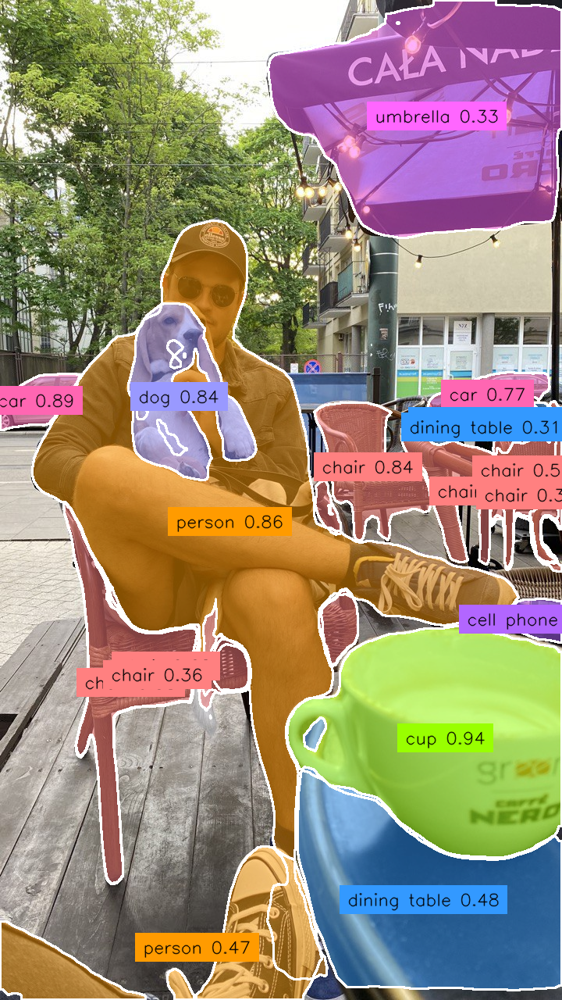

In [7]:
image = Image.open("dog-3.jpeg")

detections = model.predict(image, threshold=0.3)

annotated_image = annotate(image, detections, classes=COCO_CLASSES)
annotated_image

## Download Dataset from Roboflow Universe

RF-DETR expects the dataset to be in COCO format. Divide your dataset into three subdirectories: `train`, `valid`, and `test`. Each subdirectory should contain its own `_annotations.coco.json` file that holds the annotations for that particular split, along with the corresponding image files. Below is an example of the directory structure:

```
dataset/
├── train/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
├── valid/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
└── test/
    ├── _annotations.coco.json
    ├── image1.jpg
    ├── image2.jpg
    └── ... (other image files)
```

[Roboflow](https://roboflow.com/annotate) allows you to create segmentation datasets from scratch or convert existing datasets from formats like YOLO, and then export them in COCO JSON format for training. You can also explore [Roboflow Universe](https://universe.roboflow.com/) to find pre-labeled segmentation datasets for a range of use cases.

In [8]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/roboflow-jvuqo/creacks-eapny/4", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to creacks-4 in coco:: 100%|██████████| 4036/4036 [00:00<00:00, 4852.93it/s]


## Train RF-DETR on custom dataset

### Choose the right `batch_size`

Different GPUs have different amounts of VRAM (video memory), which limits how much data they can handle at once during training. To make training work well on any machine, you can adjust two settings: `batch_size` and `grad_accum_steps`. These control how many samples are processed at a time. The key is to keep their product equal to 16 — that’s our recommended total batch size. For example, on powerful GPUs like the A100, set `batch_size=16` and `grad_accum_steps=1`. On smaller GPUs like the T4, use `batch_size=4` and `grad_accum_steps=4`. We use a method called gradient accumulation, which lets the model simulate training with a larger batch size by gradually collecting updates before adjusting the weights.

In [9]:
import os
import torch
import gc

# Clear GPU memory and set environment variables
torch.cuda.empty_cache()
gc.collect()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

from rfdetr import RFDETRSegPreview

# Initialize model with CPU device from start
model = RFDETRSegPreview()

# Train with minimal GPU usage - let the model handle device placement
model.train(
    dataset_dir=dataset.location,
    epochs=2,
    batch_size=1,  # Keep it minimal
    grad_accum_steps=3,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    use_amp=False   # Disable mixed precision for CPU compatibility
)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights
TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=2, grad_accum_steps=3, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=1, weight_decay=0.0001, epochs=2, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-seg-preview.pt', pretrain_exclude_keys=None, pretrain_keys_modify_to

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an erro

Epoch: [0]  [   0/1239]  eta: 0:49:08  lr: 0.000100  class_error: 0.00  loss: 67.3264 (67.3264)  loss_ce: 6.0086 (6.0086)  loss_bbox: 1.2578 (1.2578)  loss_giou: 0.4768 (0.4768)  loss_mask_ce: 1.5634 (1.5634)  loss_mask_dice: 3.0755 (3.0755)  loss_ce_0: 6.2197 (6.2197)  loss_bbox_0: 0.9332 (0.9332)  loss_giou_0: 0.3876 (0.3876)  loss_mask_ce_0: 2.4690 (2.4690)  loss_mask_dice_0: 4.2485 (4.2485)  loss_ce_1: 6.1490 (6.1490)  loss_bbox_1: 1.0177 (1.0177)  loss_giou_1: 0.4063 (0.4063)  loss_mask_ce_1: 2.0175 (2.0175)  loss_mask_dice_1: 3.6842 (3.6842)  loss_ce_2: 5.8758 (5.8758)  loss_bbox_2: 1.3333 (1.3333)  loss_giou_2: 0.4979 (0.4979)  loss_mask_ce_2: 2.3701 (2.3701)  loss_mask_dice_2: 3.8424 (3.8424)  loss_ce_enc: 6.5773 (6.5773)  loss_bbox_enc: 0.6527 (0.6527)  loss_giou_enc: 0.2622 (0.2622)  loss_mask_ce_enc: 1.5488 (1.5488)  loss_mask_dice_enc: 4.4510 (4.4510)  loss_ce_unscaled: 1.2017 (1.2017)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.2516 (0.2516)  loss_giou_un

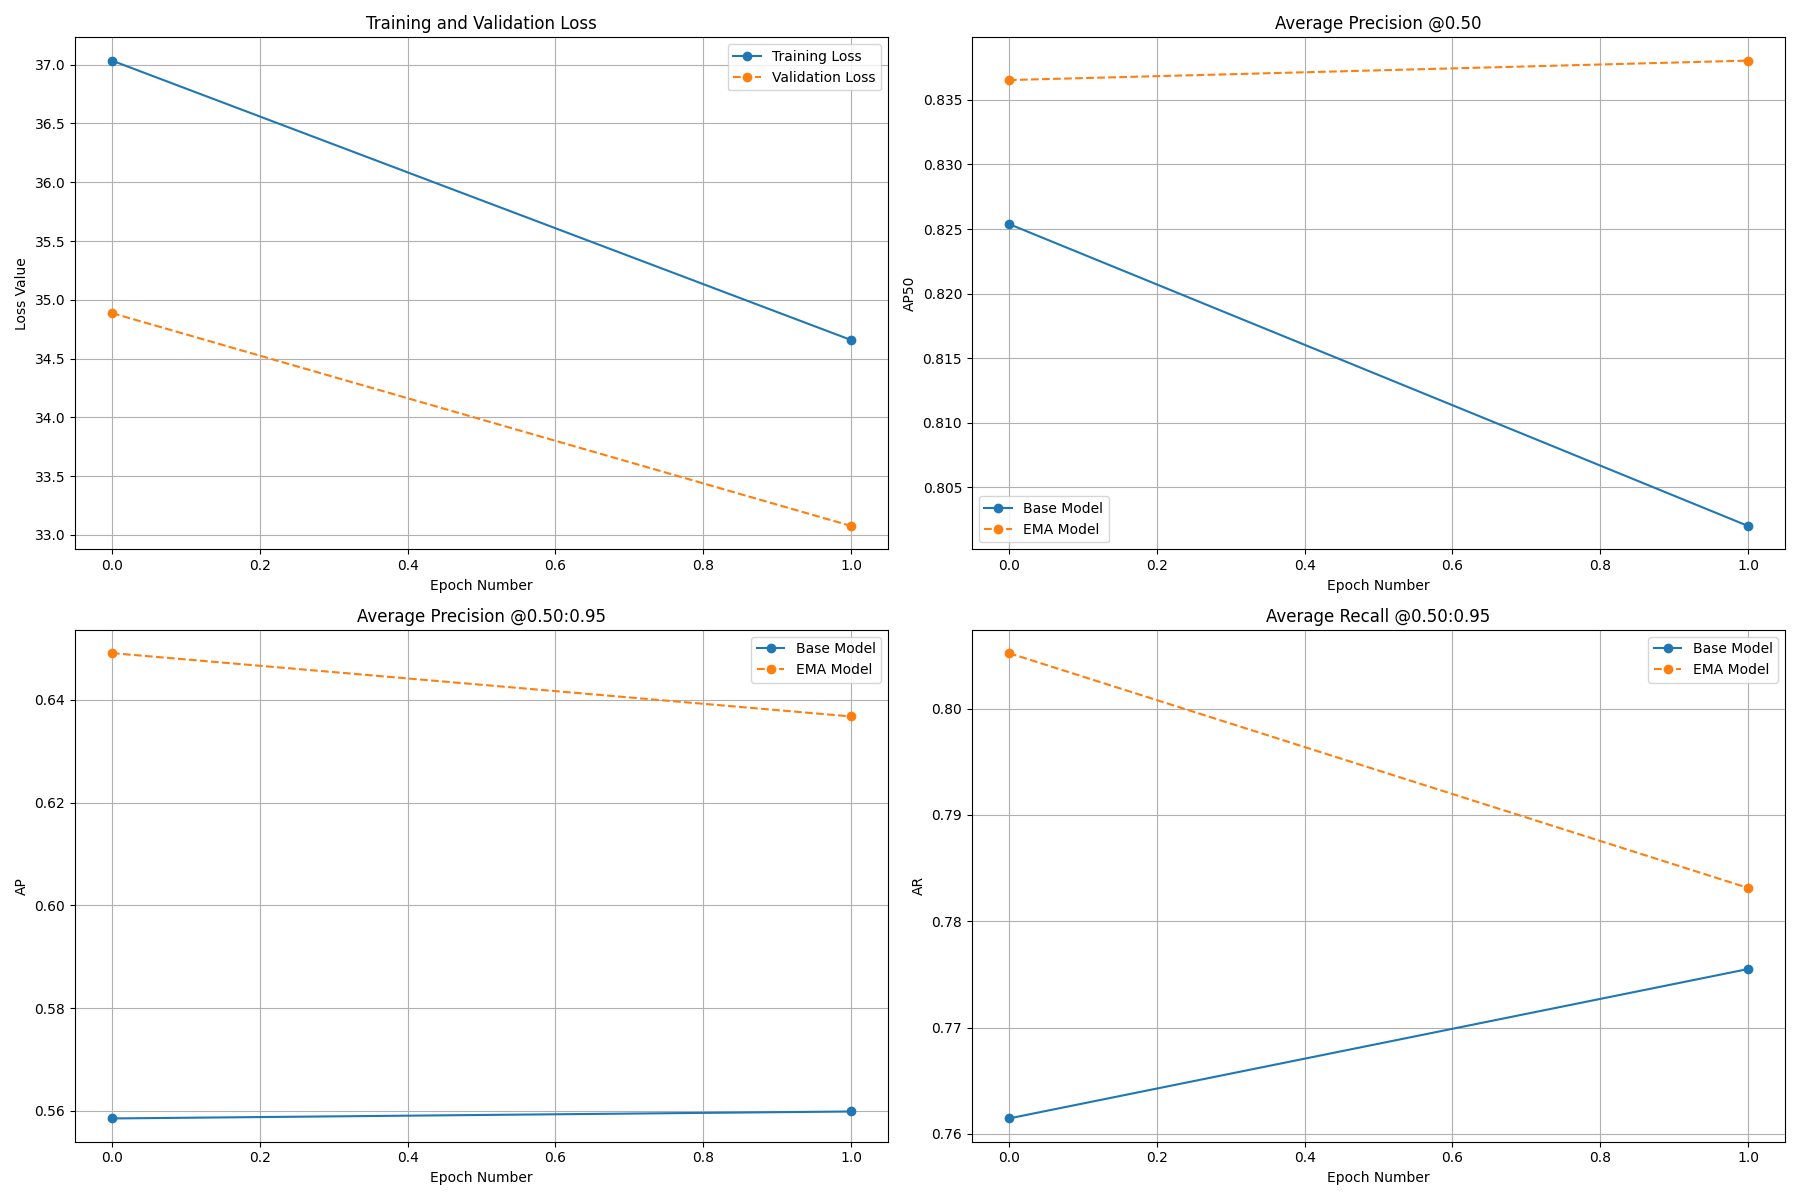

In [10]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

In [11]:
!ls -la /content/output

total 1459204
drwxr-xr-x 3 root root      4096 Nov  6 10:20 .
drwxr-xr-x 1 root root      4096 Nov  6 09:09 ..
-rw-r--r-- 1 root root 406786558 Nov  6 10:19 checkpoint_best_ema.pth
-rw-r--r-- 1 root root 408075722 Nov  6 09:42 checkpoint_best_regular.pth
-rw-r--r-- 1 root root 135558355 Nov  6 10:19 checkpoint_best_total.pth
-rw-r--r-- 1 root root 543604707 Nov  6 10:16 checkpoint.pth
drwxr-xr-x 2 root root      4096 Nov  6 09:44 eval
-rw-r--r-- 1 root root       940 Nov  6 10:19 events.out.tfevents.1762420153.67c97a22cfa6.671.0
-rw-r--r-- 1 root root     20454 Nov  6 10:19 log.txt
-rw-r--r-- 1 root root    144465 Nov  6 10:20 metrics_plot.png
-rw-r--r-- 1 root root       638 Nov  6 10:20 results.json


## Deploy a Trained RF-DETR Model

Deploying to Roboflow allows you to create multi-step computer vision applications that run both in the cloud and your own hardware. Please wait a moment while Roboflow indexes your model.

In [12]:
model.deploy_to_roboflow(
  workspace="roboflow-jvuqo",
  project_id="creacks-eapny",
  version=4,
  api_key=os.environ["ROBOFLOW_API_KEY"]
)

loading Roboflow workspace...
loading Roboflow project...
An error occured when getting the model upload URL: 404 Client Error: Not Found for url: https://api.roboflow.com/roboflow-jvuqo/creacks-eapny/4/uploadModel?api_key=IY2vfDR8sfapzCVFFNr4&modelType=rfdetr-seg-preview&nocache=true


## Evaluate Fine-tuned RF-DETR Model

Before benchmarking the model, we need to load the best saved checkpoint. To ensure it fits on the GPU, we first need to free up GPU memory. This involves deleting any remaining references to previously used objects, triggering Python’s garbage collector, and clearing the CUDA memory cache.

In [13]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [14]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 147.03 MB | Reserved: 9030.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 147.03 MB | Reserved: 324.00 MB


We load the best-performing model from the `checkpoint_best_total.pth` file using the `RFDETRSegPreview` class. This checkpoint contains the trained weights from our most successful training run. After loading, we call `optimize_for_inference()`, which prepares the model for efficient inference.

In [15]:
model = RFDETRSegPreview(pretrain_weights="/content/output/checkpoint_best_total.pth")
model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, thi

## Run Inference with Fine-tuned RF-DETR Model

In [16]:
import supervision as sv

ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
    force_masks=True
)

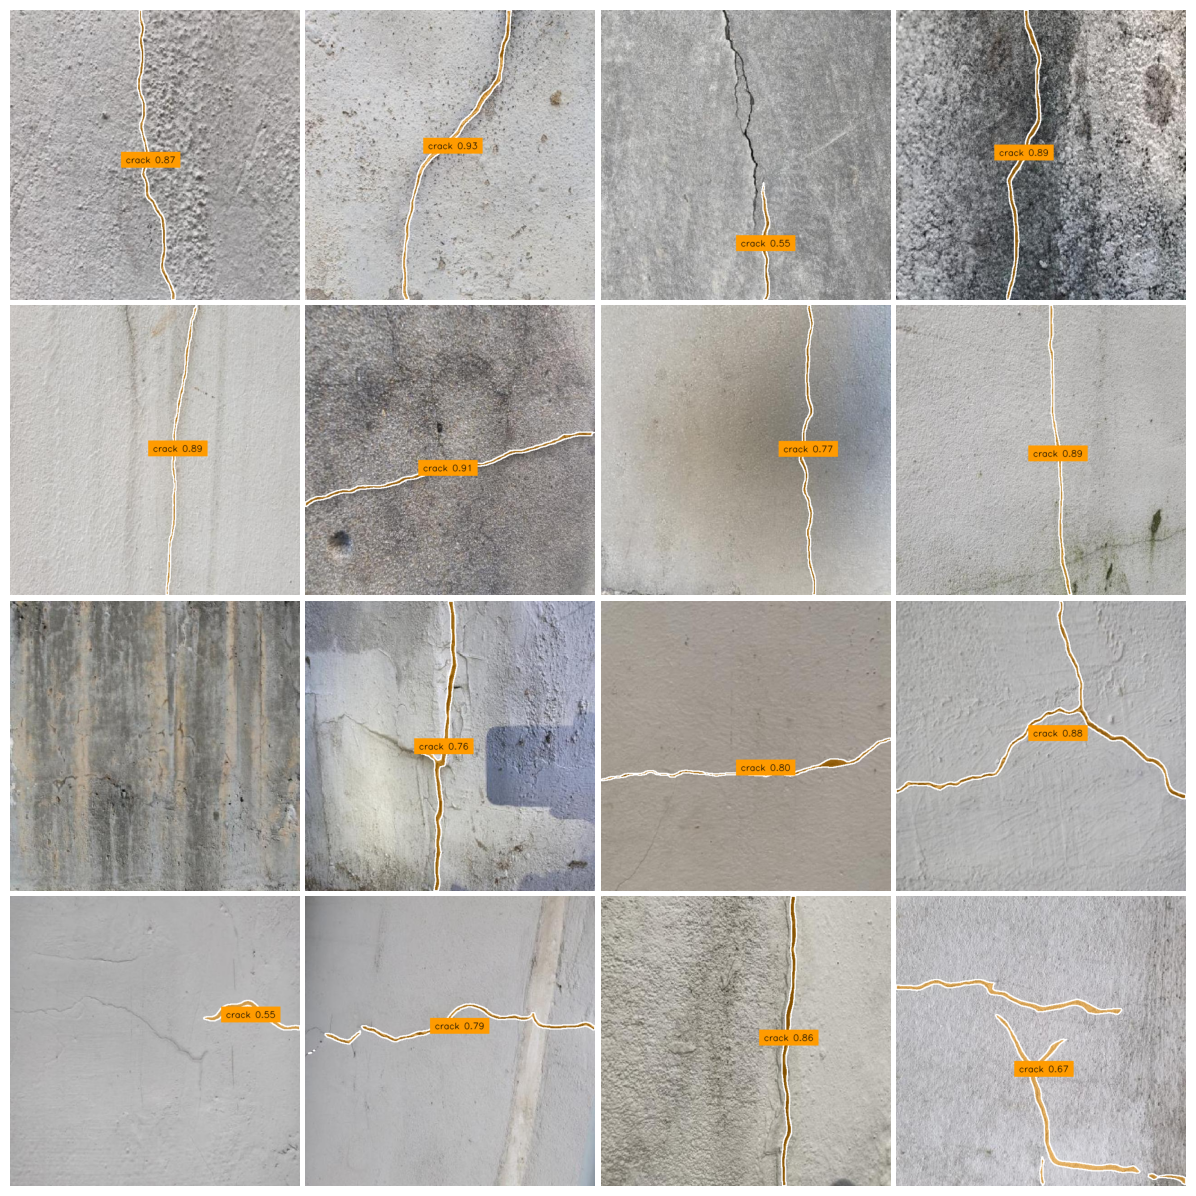

In [17]:
import random
import matplotlib.pyplot as plt

N = 16
L = len(ds_test)

annotated_images = []

for i in random.sample(range(L), N):
    path, _, annotations = ds_test[i]
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)
    annotated_image = annotate(image, detections, classes={i: class_name for i, class_name in enumerate(ds_test.classes)})
    annotated_images.append(annotated_image)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for ax, img in zip(axes.flat, annotated_images):
    ax.imshow(img)
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.99, bottom=0.01)

plt.show()

In [1]:
! pip install inference

In [2]:
from inference import get_model

MODEL_ID = "creacks-eapny/4"
ROBOFLOW_API_KEY = "IY2vfDR8sfapzCVFFNr4"  # Replace with your actual key

model_rf = get_model(model_id=MODEL_ID, api_key=ROBOFLOW_API_KEY)

ModelDependencyMissing: Your `inference` configuration does not support PaliGemma model. Use pip install 'inference[transformers]' to install missing requirements.To suppress this warning, set PALIGEMMA_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support Florence2 model. Use pip install 'inference[transformers]' to install missing requirements.To suppress this warning, set FLORENCE2_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.To suppress this warning, set QWEN_2_5_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to instal

RoboflowAPIUnsuccessfulRequestError: Unsuccessful request to Roboflow API with response code: 500

In [3]:
from inference import get_model
from google.colab import userdata

MODEL_ID = "creacks-eapny/4"
model_rf = get_model(model_id=MODEL_ID, api_key = userdata.get("ROBOFLOW_API_KEY"))

SecretNotFoundError: Secret ROBOFLOW_API_KEY does not exist.

In [21]:
import random
import matplotlib.pyplot as plt

N = 16
L = len(ds_test)

annotated_images = []

for i in random.sample(range(L), N):
    path, _, annotations = ds_test[i]
    image = Image.open(path)
    result = model_rf.infer(image, confidence=0.5)[0]
    detections = sv.Detections.from_inference(result)
    annotated_image = annotate(image, detections, classes={i: class_name for i, class_name in enumerate(ds_test.classes)})
    annotated_images.append(annotated_image)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for ax, img in zip(axes.flat, annotated_images):
    ax.imshow(img)
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.99, bottom=0.01)

plt.show()

NameError: name 'model_rf' is not defined

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>